## Importando libs

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras import Sequential
from tensorflow.keras import optimizers
from tensorflow import nn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import random
import pickle
import config
import transform_data as td

## Importando dados

In [26]:
X = pd.read_csv(f'datasets/X_{config.SYMBOL}.csv')
y = pd.read_csv(f'datasets/y_{config.SYMBOL}.csv')

In [27]:
display(X.head())
display(y.head())

,close,close%,mm7,mm14,mm21,mm200
0,1.20996,1.000008,1.210537,1.211562,1.211511,1.213447
1,1.21055,0.999513,1.210317,1.211447,1.211496,1.213462
2,1.21044,1.000091,1.210273,1.211299,1.211475,1.213475
3,1.21171,0.998952,1.210399,1.211174,1.211547,1.213490
4,1.21164,1.000058,1.210571,1.211066,1.211629,1.213502


,target
0,1.21055
1,1.21044
2,1.21171
3,1.21164
4,1.21343


## Transformando dados

In [28]:
## Quantos dados a lstm ira utilizar do passado para prever o próximo preço
step = 15

In [29]:
X_lstm, y_lstm = td.transform_lstm_data(X, y, step)

In [30]:
X_lstm.shape, y_lstm.shape

((15785, 15, 6), (15785,))

## Criando rede LSTM

In [31]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=[step, X_lstm.shape[2]], activation=nn.relu))
model.add(LSTM(50, return_sequences=True, activation=nn.relu))
model.add(LSTM(50, return_sequences=False, activation=nn.relu))
model.add(Dense(1))

model.compile(loss='mae', optimizer=optimizers.Adam(1e-3))

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 15, 50)            11400     
                                                                 
 lstm_4 (LSTM)               (None, 15, 50)            20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 51851 (202.54 KB)
Trainable params: 51851 (202.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Dividindo dados em treino e teste

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, shuffle=True, test_size=0.2)

## Treinando rede

In [34]:
hist = model.fit(X_train, y_train, batch_size=1000, epochs=20, validation_split=0.2)

Epoch 1/20
11/11 [==============================] - 7s 229ms/step - loss: 0.8941 - val_loss: 0.3229
Epoch 2/20
11/11 [==============================] - 2s 157ms/step - loss: 0.2104 - val_loss: 0.2043
Epoch 3/20
11/11 [==============================] - 2s 182ms/step - loss: 0.0890 - val_loss: 0.0481
Epoch 4/20
11/11 [==============================] - 2s 161ms/step - loss: 0.0274 - val_loss: 0.0220
Epoch 5/20
11/11 [==============================] - 2s 163ms/step - loss: 0.0157 - val_loss: 0.0097
Epoch 6/20
11/11 [==============================] - 2s 163ms/step - loss: 0.0135 - val_loss: 0.0124
Epoch 7/20
11/11 [==============================] - 2s 163ms/step - loss: 0.0086 - val_loss: 0.0108
Epoch 8/20
11/11 [==============================] - 2s 166ms/step - loss: 0.0085 - val_loss: 0.0110
Epoch 9/20
11/11 [==============================] - 2s 169ms/step - loss: 0.0097 - val_loss: 0.0299
Epoch 10/20
11/11 [==============================] - 2s 162ms/step - loss: 0.0197 - val_loss: 0.0327

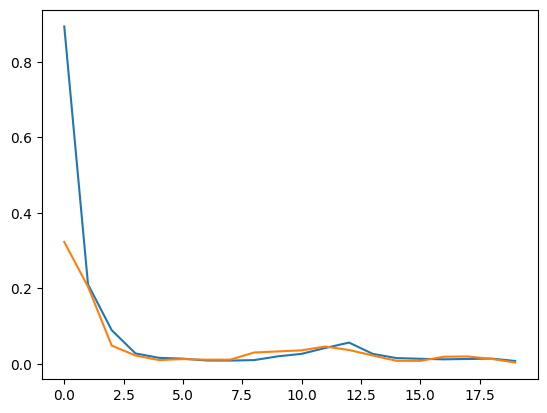

In [35]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

In [36]:
ypredLSTM = model.predict(X_test)

99/99 [==============================] - 1s 8ms/step


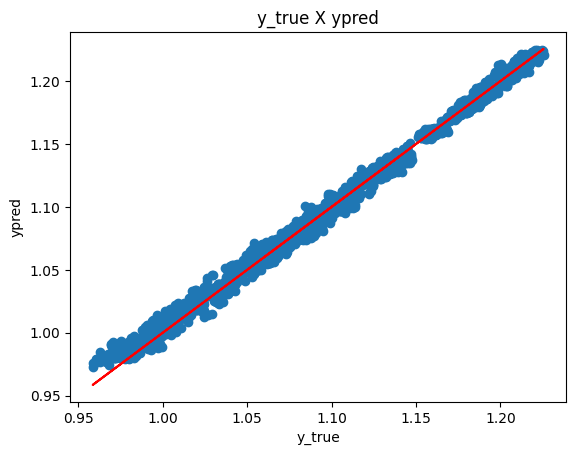

In [37]:
plt.plot(y_test, y_test, color='red')
plt.scatter(y_test, ypredLSTM)
plt.xlabel('y_true')
plt.ylabel('ypred')
plt.title('y_true X ypred');

## Métricas

In [38]:
k = X_test.shape[1]
n = len(X_test)

MSE = mean_squared_error(y_test, ypredLSTM)
MAE= mean_absolute_error(y_test, ypredLSTM)
MAPE = mean_absolute_percentage_error(y_test, ypredLSTM)
R2_Score = r2_score(y_test, ypredLSTM)
adj_r2 = 1 - (((1 - R2_Score) * (n - 1)) / (n - k - 1))

print(f'''
MSE:    {MSE}
MAE:    {MAE}
MAPE:   {MAPE*100:.2f}%
R2:     {R2_Score}
ADJ_R2: {adj_r2}
''')


MSE:    2.3818940588680464e-05
MAE:    0.003607214888106579
MAPE:   0.33%
R2:     0.9946867684871822
ADJ_R2: 0.9946613948887446



## Salvando modelo

model_filename = 'models/LSTMModel.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)